## Transfer Learning Tuning:
  * Use Resnet50 to reduce model size and improve accuracy 
      * see [base model info comparison](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
     
  * base_model: use RESNET50 and freeze at bottleneck layer (stop right before 2D AVERAGE POOL) 
  * top_model: tune dense layers (parameters are inspired by a few sources)
     * [source1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)
     * [source2](https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras)
     * [source3](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8)


  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0901 19:40:18.684003 140700394764096 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0901 19:40:18.684831 140700394764096 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
#### Import necessary libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras import optimizers

---
#### Import train_df and test_df

In [3]:
train_df = pd.read_pickle('../pickle_files/train_df_glasses.pkl')
test_df = pd.read_pickle('../pickle_files/test_df_glasses.pkl')

In [6]:
ResNet50(weights = 'imagenet',pooling = 'avg', include_top=False)

W0901 19:45:05.962327 140700394764096 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 19:45:05.963354 140700394764096 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 19:45:05.969139 140700394764096 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0901 19:45:07.050203 140700394764096 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fus

#### Get bottleneck features to tune top models

In [9]:
def save_bottleneck_features(train_df, test_df, label, batch_size):
    '''
    inputs:
    train_df, test_df: train and test dataframes saved in pickle_files folder
    label: a string, eyewear, hat, or beard
    batch_size: process images in batches
    outputs:
    saves bottleneck features inside folder tuning_data as npy file
    '''
    # intialize the vgg16 model 
    # make sure not to train the top layers 
    base_model = ResNet50(weights = 'imagenet', pooling = 'avg', include_top = False)
    # create train_generator and test_generator to get bottleneck inputs for train and test df 
    datagen = ImageDataGenerator(
        zoom_range= [0.8,1.7],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_input)
    # make sure shuffle is False so we know the label follows the sequence of the dataframe 
    # so we can tune top_model 
    train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(224,224),
    class_mode = None)
    # get features saved as .npy in tunign_data folder 
    bottleneck_features_train = base_model.predict_generator(
        train_generator, train_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/bottleneck_features_train_{label}_resnet50.npy','wb'),
           bottleneck_features_train)
    
    test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(224,224),
    class_mode = None)
    bottleneck_features_test = base_model.predict_generator(
        test_generator, test_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/bottleneck_features_test_{label}_resnet50.npy','wb'),
           bottleneck_features_test)

#### Save bottleneck_features

In [10]:
save_bottleneck_features(train_df,test_df,'eyewear',16)

Found 505 validated image filenames.
Found 127 validated image filenames.


### Quick tuning of top models 

In [6]:
def train_top_model(train_df, test_df, epoch, batch_size, label):
    '''
    inputs:
    train_df, test_df: dataframes saved in pickle_files to generate train and test labels 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    output:
    saves model weights in a folder 
    '''
    train_data = np.load(open('../tuning_data/bottleneck_features_train.npy','rb'))
    # make sure train_data and train_label have same num of samples
    train_label = np.array(train_df.eyewear.map({'not_'+label:0, label:1}))[:-(train_df.shape[0]%batch_size)]
    
    test_data = np.load(open('../tuning_data/bottleneck_features_test.npy','rb'))
    test_label = np.array(test_df.eyewear.map({'not_'+label:0, label:1}))[:-(test_df.shape[0]%batch_size)]
    
    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    model.fit(train_data, train_label,
             epochs=epoch,
             batch_size=batch_size,
             validation_data=(test_data,test_label))
    model.save_weights('../tuning_data/bottleneck_vgg_model.h5')

#### run train_top_model and save results in tuning_data

In [7]:
train_top_model(train_df, test_df, 50, 16, 'eyewear')

W0828 23:23:18.357803 139651446925120 deprecation.py:506] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0828 23:23:18.370305 139651446925120 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 23:23:18.380046 139651446925120 deprecation.py:323] From /home/mindy/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as n

Train on 496 samples, validate on 112 samples
Epoch 1/50
496/496 [==============================] - 0s 856us/step - loss: 1.4508 - acc: 0.6270 - val_loss: 0.3181 - val_acc: 0.8929
Epoch 2/50
496/496 [==============================] - 0s 193us/step - loss: 0.4379 - acc: 0.7964 - val_loss: 0.3116 - val_acc: 0.8750
Epoch 3/50
496/496 [==============================] - 0s 193us/step - loss: 0.4097 - acc: 0.8508 - val_loss: 0.4574 - val_acc: 0.7857
Epoch 4/50
496/496 [==============================] - 0s 202us/step - loss: 0.2228 - acc: 0.9032 - val_loss: 0.2842 - val_acc: 0.9018
Epoch 5/50
496/496 [==============================] - 0s 205us/step - loss: 0.2718 - acc: 0.9032 - val_loss: 0.7909 - val_acc: 0.6964
Epoch 6/50
496/496 [==============================] - 0s 197us/step - loss: 0.1653 - acc: 0.9234 - val_loss: 0.5791 - val_acc: 0.7857
Epoch 7/50
496/496 [==============================] - 0s 197us/step - loss: 0.2001 - acc: 0.9294 - val_loss: 0.4871 - val_acc: 0.8125
Epoch 8/50
496/4

### Fine Tune Top Model to improve accuracy

In [4]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, print_model = True):
    # build VGG16 model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    model_vgg = VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))
    # build top model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
    top_model.add(Dense(256,activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # load saved weights to fine tune parameters 
    top_model.load_weights('../tuning_data/bottleneck_vgg_model.h5')
    # add top model to model
    model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))
    # we will tune last 5 layers of the model: block5 and fully connected layer 
    for layer in model.layers[:15]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    train_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    # not want to augment the test 
    test_gen = ImageDataGenerator(rescale=1./255)
    
    train_generator =  train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    # run and fit model 
    history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//batch_size,
    verbose=1)
    
    if print_model:
        model.summary()
    return history                  

### save model history 

In [5]:
model_history = fine_tune_model(train_df, test_df,50,16,'eyewear')

W0828 22:36:14.788554 139674723813184 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 22:36:14.789565 139674723813184 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 22:36:14.791611 139674723813184 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 22:36:14.808292 139674723813184 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0828 22:36

Found 505 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Epoch 1/50
31/31 [==============================] - 4s 142ms/step - loss: 6.2363 - acc: 0.3933 - val_loss: 0.7344 - val_acc: 0.5089
Epoch 2/50
31/31 [==============================] - 4s 137ms/step - loss: 0.7142 - acc: 0.5603 - val_loss: 0.6393 - val_acc: 0.7568
Epoch 3/50
31/31 [==============================] - 4s 140ms/step - loss: 0.6679 - acc: 0.6107 - val_loss: 0.6403 - val_acc: 0.7297
Epoch 4/50
31/31 [==============================] - 4s 140ms/step - loss: 0.6555 - acc: 0.5955 - val_loss: 0.5844 - val_acc: 0.7658
Epoch 5/50
31/31 [==============================] - 4s 137ms/step - loss: 0.6072 - acc: 0.6774 - val_loss: 0.6024 - val_acc: 0.6216
Epoch 6/50
31/31 [==============================] - 4s 125ms/step - loss: 0.5799 - acc: 0.6894 - val_loss: 0.5150 - val_acc: 0.7748
Epoch 7/50
31/31 [==============================] - 4s 122ms/step - loss: 0.5586 - acc: 

In [6]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')

highest test accuracy: 0.972972972972973
------------------
highest train accuracy: 0.9838709677419355


In [8]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.0918908021874256
------------------
lowest train loss: 0.062466412995978125


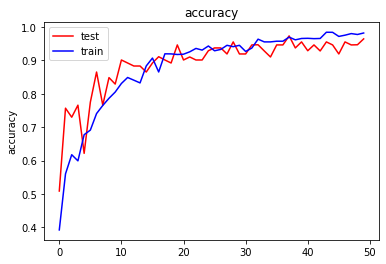

In [10]:
plt.plot(model_history.history['val_acc'], color = 'red', label = 'test')
plt.plot(model_history.history['acc'], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

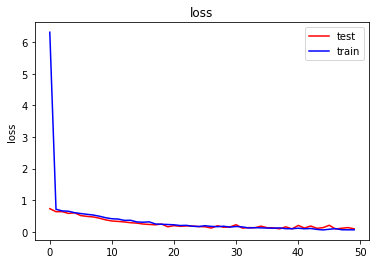

In [11]:
plt.plot(model_history.history['val_loss'], color = 'red', label = 'test')
plt.plot(model_history.history['loss'], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()